# Futurama Super-resolution
This project will aim to create higher resolution versions of early Futurama episodes. Luckily, the later seasons are in 1080p, and will therefore be used to generate ground truth and from them downscaled inputs can be generated.

First, we need to generate the training data. This will be done by converting futurama episodes into a set of images. Initially, let's start by attempting to do superresolution on 64x64 -> 128x128 squares of the image. Since the old episodes are in the format 640x480, I think a resolution of 1280x960 would be good enough. So the order of increase in resolution is 4 times as many pixels.

In [ ]:
import cv2, random, os
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, Grayscale
from tqdm.notebook import tqdm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import math

low_resolution = (64, 64)
high_resolution = (128, 128)

## Generating training data
Now we need to create the data. This is done by grabbing random crops of a Futurama episode.
![Futurma shot crop](https://github.com/Ragusaen/FuturamaSuperResolution/blob/main/resources/futurama_shot.png?raw=1)

The cropped image is then downscaled to a lower resolution, which will be the input and then the high resolution is the target for the model.

High resolution                                          | Low resolution (downscaled)
:-------------------------------------------------------:|:----------------------------------------------------:
![Shot crop high resolution](https://github.com/Ragusaen/FuturamaSuperResolution/blob/main/resources/highres_crop.png?raw=1) | ![Shot crop low resolution](https://github.com/Ragusaen/FuturamaSuperResolution/blob/main/resources/lowres_crop.png?raw=1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def img_to_tensor(img):
    return torch.from_numpy(np.asarray(img)).permute(2,0,1)[[2,1,0], :, :].float() / 256.0

if not os.path.exists('highres'):
    os.makedirs('highres')
    
if not os.path.exists('lowres'):
    os.makedirs('lowres')

cap = cv2.VideoCapture("/content/drive/MyDrive/Colab Notebooks/video/sample0.mkv")

s, frame0 = cap.read()

# Skip the first 100 frames
#cap.set(cv2.CAP_PROP_POS_FRAMES, 1000)

cw, ch = high_resolution

max_start_crop_x, max_start_crop_y = (frame0.shape[1] - cw, frame0.shape[0] - ch)

frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) - 5)

lowres_data = torch.zeros((frames,3,64,64))
highres_data = torch.zeros((frames,3,128,128))

i=0
for _ in tqdm(range(frames)):
    if not cap.isOpened():
        break
    
    ret, frame = cap.read()

    if frame is None:
      continue
    
    cx = random.randint(0, max_start_crop_x)
    cy = random.randint(0, max_start_crop_y)
    
    crop = frame[cy:(cy+ch), cx:(cx+cw)]
    lowres_crop = cv2.resize(crop, low_resolution, interpolation=cv2.INTER_AREA)
    #lowres_upscaled = cv2.resize(lowres_crop, high_resolution, interpolation=cv2.INTER_CUBIC)

    lowres_data[i] = img_to_tensor(lowres_crop)
    highres_data[i] = img_to_tensor(crop)
    i += 1

cap.release()

### Loading data to tensors
Next up, we need to load this data into the tensor format for use in pytorch. We define our own dataset `ImageInputTargetDataset`, which will be able to generate input-target datapoints from images in two different folders.

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device

device(type='cuda')

In [ ]:
def imgpath_to_tensor(img_path):
    return img_to_tensor(cv2.imread(img_path))
    
class ImageInputTargetDataset(Dataset):

    def __init__(self, input_tensor, target_tensor, transform=None):
        self.input = input_tensor
        self.target = target_tensor
        self.transform = transform
    
    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        input = self.input[idx]
        target = self.target[idx]

        if self.transform:
            input = self.transform(input)
            target = self.transform(target)

        return [input, target]

With this dataset format defined, we can create a `DataLoader` for it. This class can load the datapoints in batches.

In [ ]:
batch_size = 128

dataset = ImageInputTargetDataset(lowres_data, highres_data,
                                  transform=Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

dataloader = DeviceDataLoader(DataLoader(dataset, batch_size=batch_size, shuffle=True), device)

loss_fun = nn.MSELoss()
to_device(loss_fun, device)
;

''

In [ ]:
def denorm(img_tensors):
    return img_tensors * 0.5 + 0.5


upscale_factor = high_resolution[0]/low_resolution[0]
upsample = nn.Upsample(scale_factor=upscale_factor, mode='bilinear', align_corners=False)

def display_imgs(imgs):
    _, axs = plt.subplots(1,len(imgs), figsize=(4*len(imgs),4))
    for i in range(len(imgs)):
        axs[i].imshow(denorm(imgs[i].cpu()).permute(1,2,0), cmap='gray')

Bilinear loss:  0.0004935362376272678


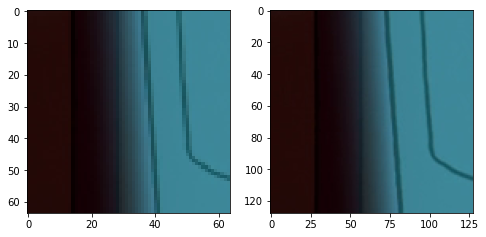

In [ ]:
for lr, hr in dataloader:
    print("Bilinear loss: ", loss_fun(upsample(lr)[0], hr[0]).item())
    display_imgs([lr[0].cpu(), hr[0].cpu()])
    break

## Creating the model 
The model that we will use is a simple transpose convolutional neural network.

In [ ]:
class ConvSubPixel(nn.Module):
    """This is the first working attempt model, it uses convolutional 
    layers and then a subpixel convolution.
    """
    
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm2d(24),
            nn.PReLU()
        )

        self.resconv = nn.Sequential(
            nn.Conv2d(24, 24, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(24),
            nn.PReLU(),

            nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(24),
            nn.PReLU()
        )
        
        # 3072x4x4
        self.sub_pixel = nn.Sequential(
            nn.Conv2d(24, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.PReLU(),

            nn.PixelShuffle(2)
        )

        self.convf = nn.Sequential(
            nn.Conv2d(24, 3, kernel_size=3, stride=1, padding=1)
        )
        
        self.final = nn.Tanh()

        self.upsample = upsample
        

    def forward(self, xb):
        upsampled = torch.atan(self.upsample(xb))

        out = self.conv1(xb)
        out = self.resconv(out) + out
        out = self.sub_pixel(out)
        out = self.convf(out)
        out = self.final(out + upsampled)

        #out = torch.clamp(out, -1.0, 1.0)
        
        return out

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.PReLU(),

            nn.Conv2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.PReLU(),

            nn.Conv2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.PReLU(),
            
            nn.Conv2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.PReLU(),

            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.PReLU(),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(),

            nn.Flatten()
        )

        self.fully_connected = nn.Sequential(
            nn.Linear(128, 32),
            nn.PReLU(),

            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, xb):
        out = self.conv(xb)
        out = self.fully_connected(out)

        return out


In [ ]:
generator = ConvSubPixel()
discriminator = Discriminator()
to_device(generator, device)
to_device(discriminator, device)

def count_parameters(model):
    return sum([p.numel() for p in model.parameters() if p.requires_grad])

print("Learnable parameters - Generator:", count_parameters(generator), " Discriminator: ", count_parameters(discriminator))

def upscale_image(img):
    out = generator(img)
    return out

Learnable parameters - Generator: 47311  Discriminator:  190121


torch.Size([3, 128, 128])


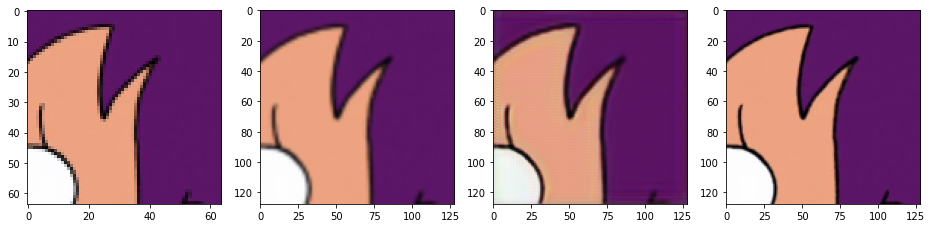

In [ ]:
for lr, hr in dataloader:
    print(upscale_image(lr).detach()[0].shape)
    bilinear = upsample(lr)[0]
    display_imgs([lr[0], bilinear, upscale_image(lr).detach()[0], hr[0]])
    break

In [ ]:
train_history = []
def train(num_epochs, lr, nbatches=-1, gen_headstart=0):
    opt_generator = torch.optim.Adam(generator.parameters(), lr=lr)
    opt_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)

    discriminator_loss_fun = nn.BCELoss()
    content_loss_fun = loss_fun
    
    generator.train()
    
    for epoch in range(num_epochs): 
        d_fake_loss = []
        d_real_loss = []
        g_gan_loss = []
        g_cont_loss = []

        i = 0
        for lowres, highres in tqdm(dataloader):
            if nbatches != -1 and i > nbatches:
                break
            
            # Reset gradients
            opt_generator.zero_grad()
            opt_discriminator.zero_grad()

            ## Train discriminator
            # Train on HR images
            real_predictions = discriminator(highres)
            real_loss = discriminator_loss_fun(real_predictions, torch.ones(highres.size(0), 1, device=device))
            d_real_loss.append(torch.mean(real_loss).item())
            
            # Train on SR images
            fakes = generator(lowres)
            fake_predictions = discriminator(fakes)
            fake_loss = discriminator_loss_fun(fake_predictions, torch.zeros(highres.size(0), 1, device=device))
            d_fake_loss.append(torch.mean(fake_loss).item())

            d_loss = real_loss + fake_loss
            d_loss.backward()

            if i < gen_headstart:
                opt_discriminator.step()

            ## Train Generator
            fakes = generator(lowres)
            fake_predictions = discriminator(fakes)
            gen_loss = discriminator_loss_fun(fake_predictions, torch.ones(highres.size(0), 1, device=device))
            cont_loss = content_loss_fun(fakes, highres)

            g_loss = cont_loss # + gen_loss
            g_gan_loss.append(torch.mean(gen_loss).item())
            g_cont_loss.append(torch.mean(cont_loss).item())
            
            g_loss.backward()
            
            opt_generator.step()
            i += 1
        
        avg_d_fake_loss = sum(d_fake_loss) / len(d_fake_loss)
        avg_d_real_loss = sum(d_real_loss) / len(d_real_loss)
        avg_g_gan_loss = sum(g_gan_loss) / len(g_gan_loss)
        avg_g_cont_loss = sum(g_cont_loss) / len(g_cont_loss)
        train_history.append([avg_d_fake_loss, avg_d_real_loss, avg_g_gen_loss, avg_g_cont_loss])
        print('Epoch [{}/{}], d_fake: {:.4f}, d_real: {:.4f}, g_gan: {:.4f}, g_cont: {:.4f}'
            .format(epoch+1, num_epochs, avg_d_fake_loss, avg_d_real_loss, avg_g_gan_loss, avg_g_cont_loss))
        torch.save(discriminator.state_dict(), '/content/drive/MyDrive/Colab Notebooks/discriminator.ckpt')
        torch.save(generator.state_dict(), '/content/drive/MyDrive/Colab Notebooks/generator.ckpt')
        
    if len(train_history) > 1:
        plt.plot(train_history)
        plt.show()

In [ ]:
discriminator.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/discriminator.ckpt'))
generator.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/generator.ckpt'))

<All keys matched successfully>

In [ ]:
train(10, 5e-4, gen_headstart=5)

NameError: ignored

In [ ]:
train(10, 1e-3)


NameError: ignored

## Things that did not work

A U-net of convolutional and deconvolutional layers did not work. At best this achieved the identity function, which is of course useless. Using res-net seems to help, but again, this makes it much easier to achieve the identity function, which means it might not be a sign that it works after all.

The first thing that was working was 3 convolutions from $3\times64\times64\rightarrow768\times8\times8$ and then a sub-pixel convolution $768\times8\times8\rightarrow3\times128\times128$.

![First working attemp model](https://github.com/Ragusaen/FuturamaSuperResolution/blob/main/resources/fwa.png?raw=1)

The result of a single subframe is shown here:

![First working attempt, subframe example](https://github.com/Ragusaen/FuturamaSuperResolution/blob/main/resources/fwa_subframe.png?raw=1)

When observing a single subframe, this looks very promising. You can notice that it looks a bit ragged, and there is also a small amount of color noise. When considering an entire frame, as shown below, the problems become more apparent.

![First working attempt, full frame original](https://github.com/Ragusaen/FuturamaSuperResolution/blob/main/resources/fwa_original.png?raw=1)
![First working attempt, full frame upscaled](https://github.com/Ragusaen/FuturamaSuperResolution/blob/main/resources/fwa_upscaled.png?raw=1)

It is definitely not bad, but it is also not great. This model works really well in dealing with 

In [ ]:
# Switch model to evaluation mode to not keep track of gradients
model.eval()

# Get video
cap = cv2.VideoCapture("/content/drive/MyDrive/Colab Notebooks/video/lowres_sample0.mkv")

video_resolution = (640, 480)

cap.set(cv2.CAP_PROP_POS_FRAMES, 12000)

# Number of subframes per axis per frame
n_subframes = (math.floor(video_resolution[0] / low_resolution[0]),
               math.floor(video_resolution[1] / low_resolution[1]))

target_resolution = (n_subframes[0] * high_resolution[0],
                     n_subframes[1] * high_resolution[1])

_, frame = cap.read()

# Resize to actual resolution
frame = cv2.resize(frame, video_resolution, interpolation=cv2.INTER_CUBIC)

cv2.imwrite('resources/original_frame.png', frame)

# Create a new empty image to insert the upscaled into
upscaled_image = np.zeros((target_resolution[1], target_resolution[0], 3), np.uint8)

normalize = Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# Create normalized tensor
norm = torch.unsqueeze(normalize(img_to_tensor(frame)), dim=0)

# Upscale it using SR model
up_tensor = model(norm.cuda()).detach()[0]

# Denormalise it and turn it into a opencv2 mat
denormed = denorm(up_tensor).cpu()
up_mat = denormed[[2,1,0], :, :].permute(1,2,0).numpy() * 256.0

cv2.imwrite('resources/upscaled_frame.png', up_mat)
        

True

In [ ]:
def img_to_tensor(img):
    return torch.from_numpy(np.asarray(img)).permute(2,0,1)[[2,1,0], :, :].float() / 256.0

if not os.path.exists('highres'):
    os.makedirs('highres')
    
if not os.path.exists('lowres'):
    os.makedirs('lowres')

cap = cv2.VideoCapture("/content/drive/MyDrive/Colab Notebooks/video/sample0.mkv")

s, frame0 = cap.read()

# Skip the first 100 frames
#cap.set(cv2.CAP_PROP_POS_FRAMES, 1000)

cw, ch = high_resolution

max_start_crop_x, max_start_crop_y = (frame0.shape[1] - cw, frame0.shape[0] - ch)

frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) - 5)

lowres_data = torch.zeros((frames,3,64,64))
highres_data = torch.zeros((frames,3,128,128))

i=0
for _ in tqdm(range(frames)):
    if not cap.isOpened():
        break
    
    ret, frame = cap.read()

    if frame is None:
      continue
    
    cx = random.randint(0, max_start_crop_x)
    cy = random.randint(0, max_start_crop_y)
    
    crop = frame[cy:(cy+ch), cx:(cx+cw)]
    lowres_crop = cv2.resize(crop, low_resolution, interpolation=cv2.INTER_AREA)
    #lowres_upscaled = cv2.resize(lowres_crop, high_resolution, interpolation=cv2.INTER_CUBIC)

    lowres_data[i] = img_to_tensor(lowres_crop)
    highres_data[i] = img_to_tensor(crop)
    i += 1

cap.release()

NameError: ignored